# Проект: Продвинутые техники подготовки данных

***Примечание к проекту:***

*Данный проект — это логическое продолжение предыдущего `before_california_housing_spark`, направленное на отработку продвинутых методов предобработки и подготовки данных (после размышлений о корректности выполненной работы ранее), а именно — ***заполнение пропусков методом*** `MICE`, ***снижение размерности, применение статистических тестов, применение компрессии данных***. Данный проект будет уже выполняться без использования `Spark`, так как цели отрабатывать методы работы с этой средой в рамках этого проекта нет. Также мы возьмем датасет изначальный, без преобразованных, как было в предыдущем проекте. Задача стоит та же, что и ранее, предсказать медианную стоимость жилья для жилищного массива с помощью линейной регрессии.*

---

**Описание проекта:** Предсказание медианной стоимости жилья в Калифорнии с использованием линейной регрессии.

**Цель проекта:** Разработать и обучить модели машинного обучения для предсказания медианной стоимости дома в жилых массивах Калифорнии на основе различных комбинаций признаков, используя линейную регрессию, и сравнить разные подходы к предобработке и подготовке данных и как они влияют на предсказательную способность базовой модели.

**Описание данных:**

`california_housing_prices` — данные о жилье в Калифорнии 1990 года.

[🔗Ссылка на датасет](https://www.kaggle.com/datasets/camnugent/california-housing-prices)

**Описание признаков:**

- `longitude` — широта;
- `latitude` — долгота;
- `housing_median_age` — медианный возраст дома в пределах квартала *(меньшее число - это более новое здание)*;
- `total_rooms` — общее количество комнат в домах жилого массива;
- `total_bedrooms` — общее количество спален в домах жилого массива;
- `population` — количество человек, которые проживают в жилом массиве;
- `households` — количество домовладений в жилом массиве;
- `median_income` — медианный доход жителей жилого массива *(единица измерения 10.000 US Dollars)*;
- `median_house_value` — медианная стоимость дома в жилом массиве *(**Целевой признак** / единица измерения US Dollars)*;
- `ocean_proximity` — близость к океану.

**Ход исследования:**

- ***Подготовка данных***: загрузка и изучение общей информации из представленного датасета.
- ***Предобработка данных***: обработка пропущенных значений, корректировка типов данных и дубликатов.
- ***Исследовательский анализ данных***: изучение признаков имеющихся в датасетах, их распределение, поиск выбросов/аномалий в данных.
- ***Корреляционный анализ***:
- ***Подготовка данных:***
- ***Обучение моделей***:
- ***Анализ результатов***:

***Общий вывод***:

## Подготовка рабочей среды:

### Импорт библиотек:

In [2]:
import numpy as np
import math
from IPython.display import display
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import anderson
from statsmodels.stats.outliers_influence import variance_inflation_factor
import phik
import shap
import miceforest as mf
from sklearn.model_selection import train_test_split
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import StandardScaler

### Базовые настройки блокнота:

In [3]:
# Стиль графиков по умолчанию
sns.set()
sns.set_context('notebook')
# Убираем ограничения на количество колонок
pd.set_option('display.max_column', None)
# Убираем ограничение на количество символов в ячейках
pd.set_option('display.max_colwidth', None)
# Константа для random_state
RANDOM_STATE = 6011994

### Функции:

In [4]:
# Функция для получения общей информации о датафрейме
def gen_info(df):
    '''
    Данная функция выводит общую информацию 
    о датафрейме, статистическое описание признаков
    и 5 рандомных строк.
    На ввод функция принимает переменную датафрейма.
    '''
    # Статистики по количественным признакам
    desc = df.describe().T

    # Подсчет коэффициента вариативности значений
    desc['cv_coef'] = desc['std'] / desc['mean']

    # Вывод результатов
    print(df.info())
    display(desc)
    display(df.sample(5, random_state=RANDOM_STATE))

In [5]:
# Функция для поиска неявных дубликатов
def hidden_dup_search(df):
    '''
    Данная функция приводит значения категориальных 
    столбцов к единому стилю и выводит их уникальные 
    значения.
    На ввод функция принимает переменную датафрейма.
    '''
    
    # Список категориальных признаков
    df_cat_col = df.select_dtypes(exclude = 'number').columns.tolist()

    # Приводим все значения к единому стилю
    # и проверяем уникальные значения для 
    # точечной проработки при необходимости
    for feature in df_cat_col:
        df[feature] = df[feature].str.lower().str.replace(' ', '_')
        print(f'Уникальные значения признака: {str(feature)}')
        print(df[feature].unique())
        print()

In [6]:
# Функция для комплексного анализа количественного признака
def analyzis_quantity(df, x_label, y_label='Частота', target=None, 
                      hue=None, system=False, discrete=False, 
                      log_scale=False, title_hist=None, title_scatter=None):
    '''
    Данная функция выводит "коробочный" график и гистограмму 
    по указанному столбцу датафрейма и его статистические метрики.
    Аргументы функции:
    df - данные (pd.Series)
    x_label - подпись для оси Х
    y_label - подпись для оси Y (по умолчанию "Частота")
    target - целевая переменная для scatter-графика (если system=True)
    hue - переменная для цветового кодирования (если system=True)
    system - флаг для построения scatter-графика
    discrete - булевое значение, дискретные значение или нет.
    log_scale - логарифмическая шкала для гистограммы
    title_hist - заголовок для гистограммы и boxplot
    title_scatter - заголовок для scatter-графика
    '''

    # Названия для графиков по умолчанию
    if title_hist is None:
        title_hist = f"Распределение {df.name if hasattr(df, 'name') else 'входной признак'}"
    if title_scatter is None:
        target_name = target.name if hasattr(target, 'name') else 'таргета'
        feature_name = df.name if hasattr(df, 'name') else 'входной признак'
        title_scatter = f"Зависимость {target_name} от {feature_name}"
    
    # Создание составного графика: boxplot + histogram
    fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, 
                                          figsize=(6, 4.2), 
                                          gridspec_kw={'height_ratios': (.15, .85)})
    
    # Boxplot
    sns.boxplot(x=df, orient='h', ax=ax_box)
    ax_box.set(xlabel='')

    # Histogram
    n_bins = round(1 + math.log2(len(df))) if len(df) > 1 else 10
    sns.histplot(x=df, bins=n_bins, discrete=discrete, log_scale=log_scale, ax=ax_hist)

    # Общие настройки для основной фигуры
    ax_hist.set_xlabel(x_label, fontsize=10)
    ax_hist.set_ylabel(y_label, fontsize=10)
    ax_hist.tick_params(axis='both', which='major', labelsize=10)
    fig.suptitle(title_hist, fontsize=12, fontweight='bold', y=0.95)

    # Настройка тиков для дискретных значений
    if discrete:
        ax_hist.set_xticks(np.arange(df.min(), df.max() + 1, 1))

    # Отображение первой фигуры
    fig.tight_layout()

    # Scatter plot (если запрошено)
    if system:
        if hue is not None:
            fig_2, ax_2 = plt.subplots(figsize=(7.5, 4))
        else:
            fig_2, ax_2 = plt.subplots(figsize=(6, 4))
        sns.scatterplot(x=df, y=target, alpha=0.5, hue=hue, ax=ax_2)
        fig_2.suptitle(title_scatter, fontsize=12, fontweight='bold', y=0.95)
        ax_2.set_xlabel(x_label, fontsize=10)
        ax_2.set_ylabel(target.name if hasattr(target, 'name') else 'Целевая переменная', fontsize=10)
        ax_2.tick_params(axis='both', which='major', labelsize=10)
        if hue is not None:
            ax_2.legend(bbox_to_anchor=(1.025, 1), loc='upper left', fontsize=10)
        fig_2.tight_layout()

    # Отображение графика
    plt.show()

    # Вывод статистических метрик
    display(df.describe().to_frame().T)
        
    # Проверяем нормальность распределения
    result = anderson(df.dropna())
    
    if result.statistic < result.critical_values[2]:
        distr = 'Нормальное'
    else:
        distr = 'Не является нормальным'

    test_anderson = {'':['Статистика:', 
                         "Критические значения:", 
                         'Распределение'], 
                     'Тест на нормальность распределения (порог=0.05):': [result.statistic, 
                                                                          result.critical_values, 
                                                                          distr]
                    }
    display(pd.DataFrame(test_anderson).set_index(''))

In [87]:
# Функция для анализа категорийных значений

def analyzis_category(df, title=None, kind='bar'):
    '''
    Данная функция выводит столбчатый график
    по указанному столбцу датафрейма и его значения 
    в табличном виде.
    Аргументы функции:
    df - данные
    name - название графика
    kind - ориентация графика вертикальная или 
    горизонтальная, принимает значения "bar" и "barh".
    '''
    # Название для графика по умолчанию
    if title is None:
        title = f"Соотношение категорий {df.name if hasattr(df, 'name') else 'входного признака'}"
    
    # Подсчитываем количество каждого значения
    category_count = df.value_counts(ascending=True)

    # Создание столбчатого графика
    plot_bar = category_count.plot(kind=kind, figsize=(6, 4), grid=True)

    # Настройка заголовка и подписей
    if kind == 'bar':
        plt.title(title, fontweight='bold', fontsize=12)
        plt.xlabel('')
        plt.ylabel('Частота', fontsize=10)
        plt.tick_params(axis='both', which='major', labelsize=10)
        plt.xticks(rotation=0)
    
    else:
        plt.title(title, fontweight='bold', fontsize=12)
        plt.xlabel('Частота', fontsize=10)
        plt.ylabel('')
        plt.tick_params(axis='both', which='major', labelsize=10)
        plt.xticks(rotation=0)

    # Отображаем график
    plt.tight_layout()
    plt.show()

    # Вывод значений в табличном виде
    display(pd.DataFrame(category_count).reset_index().style.hide(axis='index'))

In [8]:
# Построение таблицы с расчитанным VIF
def vif_factor(data, columns):
    '''
    Данная функция расчитываем VIF-фактор
    для количественных признаков датафрейма.
    На ввод функция принимает:
    data - датафрейм
    columns - список количественных признаков.
    '''
    vif_data = pd.DataFrame()
    vif_data['input attribute'] = columns
    vif_data['vif'] = ([variance_inflation_factor(data[columns].values, i) 
                        for i in range(data[columns].shape[1])])
    return vif_data

In [9]:
# Функция для линейной компрессии данных
def linear_compress(df, threshold, ratio):
    '''
    Функция для линейной копрессии данных,
    пики превышающие порог сжимаются на
    коэффициент ratio.
    
    Аргументы:
    df - pd.Series (оригинальный признак для компрессии);
    threshold - порог срабатывания компрессора;
    ratio - коэффициент сжатия.

    Вывод: pd.Series.
    '''
    def ln_compress(x):
        if x <= threshold:
            return x
        else:
            return threshold + (x - threshold) / ratio
    return df.map(ln_compress)

In [10]:
# Функция для степенной компрессии данных
def power_compress(df, threshold, power):
    '''
    Функция для степенной копрессии данных,
    пики превышающие порог масштабируются c
    соответствнно размеру коэффициента power.
    
    Аргументы:
    df - pd.Series (оригинальный признак для компрессии);
    threshold - порог срабатывания компрессора (передавать значение квантиля);
    power - степень сжатия.

    Вывод: pd.Series.
    '''
    def pw_compress(x):
        if x <= threshold:
            return x
        else:
            return threshold + (x - threshold) ** power
    
    return df.map(pw_compress)

In [11]:
# Функция для логарифмической компрессии данных
def log_compress(df, threshold, scale):
    '''
    Функция для логарифмической копрессии данных,
    пики превышающие порог сжимаются практичиески
    до уровня порога, увеличения коэффициента
    scale может немного ослабить силу сжатия.
    
    Аргументы:
    df - pd.Series (оригинальный признак для компрессии);
    threshold - порог срабатывания компрессора (передавать значение квантиля);
    scale - коэффициент ослабления силы сжатия.

    Вывод: pd.Series.
    '''
    def lg_compress(x):
        if x <= threshold:
            return x
        else:
            return threshold + np.log1p(x - threshold) * scale
    
    return df.map(lg_compress)

In [12]:
# Функция для преобразования значений долготы и широты в 3д координаты
def to_3d(lat, lon):
    '''
    Данная функция преобразовывает значения 
    долготы и широты в массив с 3д координатами
    этих точек.
    Аргументы:
    lat - широта
    lon - долгота

    Вывод: массив 3д координат (np.array).
    '''
    lat_rad = np.radians(lat)
    lon_rad = np.radians(lon)
    x = np.cos(lat_rad) * np.cos(lon_rad)
    y = np.cos(lat_rad) * np.sin(lon_rad)
    z = np.sin(lat_rad)
    return np.array([x, y, z]).T

## Общая информация о данных:

### Загрузка данных:

In [13]:
df = pd.read_csv('./housing.csv')

### Знакомство с данными:

In [14]:
gen_info(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB
None


count           mean            std         min  \
longitude           20640.0    -119.569704       2.003532   -124.3500   
latitude            20640.0      35.631861       2.135952     32.5400   
housing_median_age  20640.0      28.639486      12.585558      1.0000   
total_rooms         20640.0    2635.763081    2181.615252      2.0000   
total_bedrooms      20433.0     537.870553     421.385070      1.0000   
population          20640.0    1425.476744    1132.462122      3.0000   
households          20640.0     499.539680     382.329753      1.0000   
median_income       20640.0       3.870671       1.899822      0.4999   
median_house_value  20640.0  206855.816909  115395.615874  14999.0000   

                            25%          50%           75%          max  \
longitude             -121.8000    -118.4900    -118.01000    -114.3100   
latitude                33.9300      34.2600      37.71000      41.9500   
housing_median_age      18.0000      29.0000      37.00000      52.0000   
total_rooms           1447.7500    2127.0000    3148.00000   39320.0000   
total_bedrooms         296.0000     435.0000     647.00000    6445.0000   
population             787.0000    1166.0000    1725.00000   35682.0000   
households             280.0000     409.0000     605.00000    6082.0000   
median_income            2.5634       3.5348       4.74325      15.0001   
median_house_value  119600.0000  179700.0000  264725.00000  500001.0000   

                     cv_coef  
longitude          -0.016756  
latitude            0.059945  
housing_median_age  0.439448  
total_rooms         0.827698  
total_bedrooms      0.783432  
population          0.794444  
households          0.765364  
median_income       0.490825  
median_house_value  0.557855

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
15688    -122.43     37.79                52.0       3486.0           847.0   
8874     -118.45     34.06                52.0        204.0            34.0   
7813     -118.11     33.90                35.0       2604.0           495.0   
3994     -118.57     34.17                35.0       2072.0           318.0   
11439    -117.98     33.61                17.0       2054.0           291.0   

       population  households  median_income  median_house_value  \
15688      1248.0       813.0         7.2623            500001.0   
8874       1154.0        28.0         9.3370            500001.0   
7813       1465.0       470.0         4.4896            184600.0   
3994        908.0       342.0         6.0928            327300.0   
11439       836.0       288.0         6.8939            383900.0   

      ocean_proximity  
15688        NEAR BAY  
8874        <1H OCEAN  
7813        <1H OCEAN  
3994        <1H OCEAN  
11439      NEAR OCEAN

### Деление на обучающую и тестовую выборку:

Для честности проведенной работы сразу разделим данные на обучающую и тестовую выборку, вся работа будет проходить с обучающей выборкой, а на тестовой только оценим результат проделанной работы.

In [16]:
# Входные признаки
X = df.drop(['median_house_value'], axis=1)
# Таргет
y = df['median_house_value']

In [20]:
# Деление на тренировочные и тестовые данные
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y, 
    test_size=0.2, 
    random_state=RANDOM_STATE, 
    stratify=df['ocean_proximity']
)

In [21]:
# Проверка результата деления данных
print(f'Тренировочные входные признаки: {X_train.shape}')
print(f'Тренировочный таргет: {y_train.shape}')
print(f'Тестовые входные признаки: {X_test.shape}')
print(f'Тестовый таргет: {y_test.shape}')

Тренировочные входные признаки: (16512, 9)
Тренировочный таргет: (16512,)
Тестовые входные признаки: (4128, 9)
Тестовый таргет: (4128,)


In [22]:
# Объединение обучающей выборки для продолжения работы
df = pd.concat([X_train, y_train], axis=1)

In [25]:
# Проверяем результат объединения
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16512 entries, 14848 to 16799
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16347 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
 8   ocean_proximity     16512 non-null  object 
 9   median_house_value  16512 non-null  float64
dtypes: float64(9), object(1)
memory usage: 1.4+ MB


### Вывод:

В данном разделе мы познакомились с общей информацией о датафрейме, а так же разделили датасет на обучающий и тестовый набор данных. Теперь можем приблизительно составить план для предобработки данных и дальнейшей работе:

- Строки с пропущенными значениями надо рассмотреть и понять природу их возникновения, по возможности их восстановить, но их количество не так велико *(около 1%)*, если там будет наблюдатся сложная зависимость, имеет смысл просто от них отказаться, чтобы не снижать качество данных;
- После заполнения или удаления пропусков можем часть признаков преобразовать в целочисленные типы данных;
- Изменим масштаб значений признака `median_income` в изначальный вид, для удобства восприятия *(умножим на 10000)*;
- Необходимо данные проверить на наличие явных и неявных дубликатов.

## Предобработка данных:

### Пропущенные значения:

Рассмотрим строки с пропущенными значениям и попытаемся понять природу их возникновения.

In [26]:
df_na = df.query('total_bedrooms.isna()')

In [27]:
df_na.sample(15, random_state=RANDOM_STATE)

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
16025    -122.44     37.73                39.0       1912.0             NaN   
6052     -117.76     34.04                34.0       1914.0             NaN   
7668     -118.08     33.92                38.0       1335.0             NaN   
20268    -119.18     34.19                19.0       2393.0             NaN   
19638    -120.97     37.43                27.0       1380.0             NaN   
3958     -118.59     34.20                21.0       1789.0             NaN   
18246    -122.08     37.39                 4.0       2292.0             NaN   
19890    -119.15     36.29                18.0       1435.0             NaN   
11441    -117.98     33.73                18.0       3833.0             NaN   
14386    -117.23     32.75                 5.0       1824.0             NaN   
4391     -118.27     34.07                27.0       1190.0             NaN   
538      -122.28     37.78                29.0       5154.0             NaN   
2301     -119.78     36.82                25.0       5016.0             NaN   
19060    -122.41     38.16                37.0       1549.0             NaN   
10389    -117.66     33.58                 6.0       4186.0             NaN   

       population  households  median_income ocean_proximity  \
16025       970.0       406.0         4.7813        NEAR BAY   
6052       1564.0       328.0         2.8347          INLAND   
7668       1011.0       269.0         3.6908       <1H OCEAN   
20268      1938.0       762.0         1.6953      NEAR OCEAN   
19638       810.0       262.0         2.1875          INLAND   
3958       2300.0       677.0         2.7540       <1H OCEAN   
18246      1050.0       584.0         4.8036        NEAR BAY   
19890       657.0       254.0         2.4281          INLAND   
11441      2192.0       996.0         3.4679       <1H OCEAN   
14386       892.0       426.0         3.4286      NEAR OCEAN   
4391       1795.0       422.0         1.7016       <1H OCEAN   
538        3741.0      1273.0         2.5762        NEAR BAY   
2301       2133.0       928.0         3.6250          INLAND   
19060       863.0       275.0         2.7457        NEAR BAY   
10389      1794.0       541.0         9.6986       <1H OCEAN   

       median_house_value  
16025            275500.0  
6052             115800.0  
7668             157500.0  
20268            167400.0  
19638            137500.0  
3958             179800.0  
18246            340000.0  
19890             72500.0  
11441            219700.0  
14386            137500.0  
4391             160000.0  
538              173400.0  
2301              89500.0  
19060            254700.0  
10389            357600.0

На данном этапе достаточно сложно выявить закономерность, по которой стоит расчитывать средние значения, заполняя пропуски медианой будет слишком поверхностно и грубо, таким образом мы снизим качество данных, поэтому принято следующее решение, применить метод `MICE` для заполнения пропусков, обычно такой метод дает более точные значения, тем не менее при обучении моделей мы рассмотрим варианты, когда пропуски просто удалены либо заполнены медианой, для сравнения результатов.

#### Применения метода MICE:

In [28]:
# Проверяем наличие неявных дубликатов в категориальных признаках
hidden_dup_search(df)

Уникальные значения признака: ocean_proximity
['near_ocean' '<1h_ocean' 'inland' 'near_bay' 'island']



Неявных дубликатов нет, можем начать подготовку данных для заполнения пропусков

In [29]:
# Преобразуем тип данных для категориальных признаков
df['ocean_proximity'] = df['ocean_proximity'].astype('category')

In [31]:
# Сбрасываем индекс для корректной работы алгоритма
df = df.reset_index(drop=True)

In [32]:
# Создаем ядро
kernel = mf.ImputationKernel(data=df,
                             num_datasets=4,
                             mean_match_candidates=10,
                             random_state=RANDOM_STATE)

In [33]:
# Заполням пропуски
kernel.mice(2)

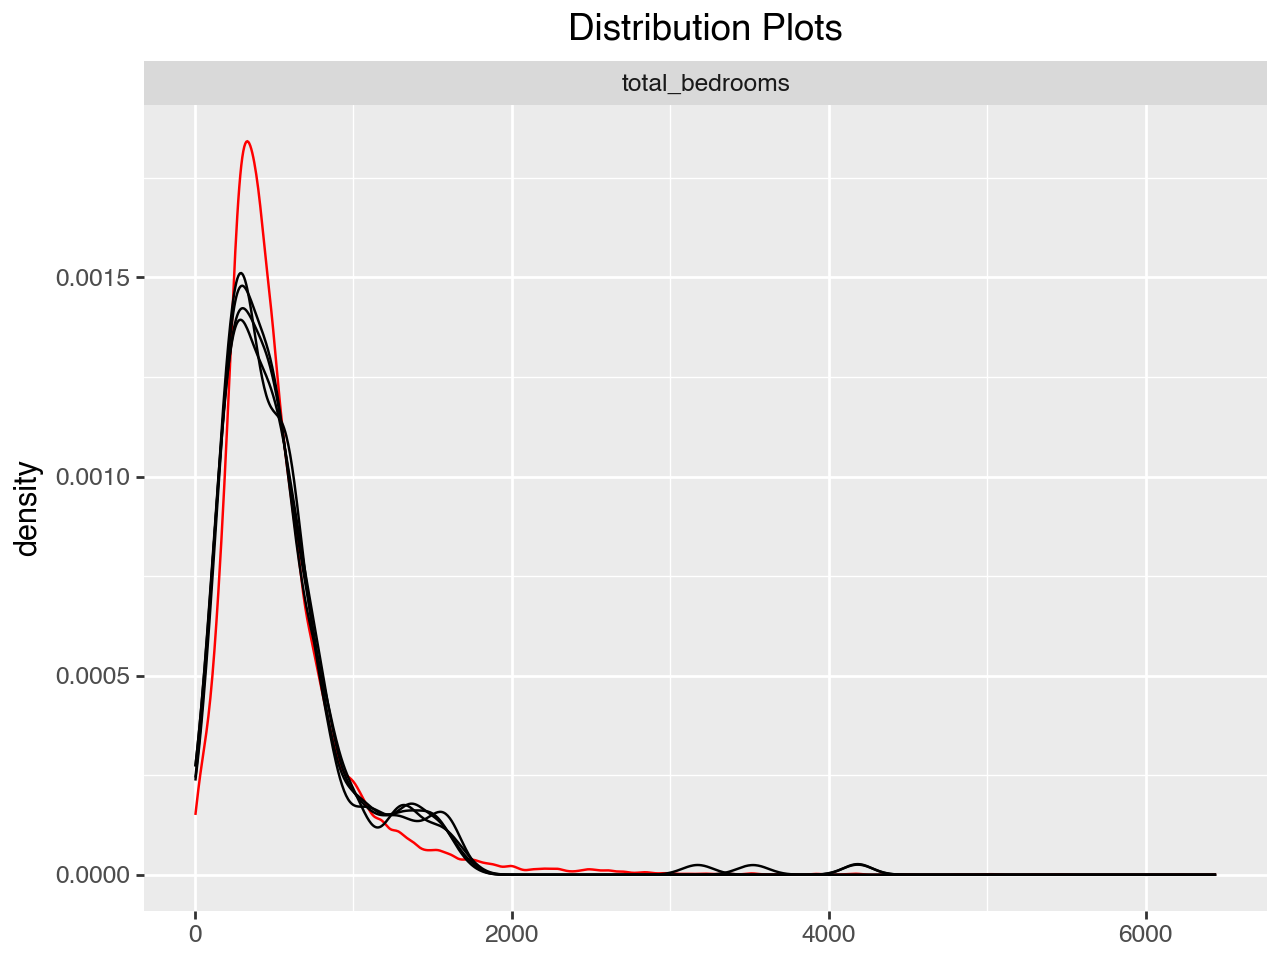

In [34]:
# Визуализация для сравнения распределения значений
kernel.plot_imputed_distributions()

По графику видим, что модель неплохо справилась с заполнением значений:

- Нет смещения;
- Хвост схож реальным распределением;
- Пик в заполненых значениях выше реального распределения, но это может быть связано с маленьким количеством пропусков.

Дополнительно проверим статистики для оригинальных и импутированных значений.

In [35]:
original = df['total_bedrooms'].dropna()
imputed = kernel.complete_data()['total_bedrooms']

print('Оригинал:')
print(f'  Среднее: {original.mean():.2f}')
print(f'  Медиана: {original.median():.2f}')
print(f'  Стандартное отклонение: {original.std():.2f}')

print('\nИмпутировано:')
print(f'  Среднее: {imputed.mean():.2f}')
print(f'  Медиана: {imputed.median():.2f}')
print(f'  Стандартное отклонение: {imputed.std():.2f}')

Оригинал:
  Среднее: 537.64
  Медиана: 435.00
  Стандартное отклонение: 416.35

Импутировано:
  Среднее: 537.61
  Медиана: 435.00
  Стандартное отклонение: 416.22


Результаты импутации показали высокую точность: среднее, медиана и стандартное отклонение импутированных значений практически совпадают с исходными. График плотности подтверждает сохранение формы распределения. Это говорит о том, что модель корректно восстановила пропущенные данные без внесения систематических искажений.

Можно с уверенностью использовать эти данные для дальнейшего анализа, визуализации и обучения моделей машинного обучения.

In [36]:
# Заменяем оригинальную на импутированную колонку
df['total_bedrooms'] = kernel.complete_data()['total_bedrooms']
# Преобразовываем категориальный признак обратно в тип данных object
df['ocean_proximity'] = df['ocean_proximity'].astype('object')

In [37]:
# Проверяем результат
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16512 entries, 0 to 16511
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16512 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
 8   ocean_proximity     16512 non-null  object 
 9   median_house_value  16512 non-null  float64
dtypes: float64(9), object(1)
memory usage: 1.3+ MB


Пропуски заполнены.

### Преобразование типов данных:

Прежде, чем преобразовывать типы данных, перепроверим все ли значения в признаках целочисленные.

In [38]:
# Предварительно восстановим масштаб признака "median_income"
df['median_income'] = df['median_income'] * 10000

In [39]:
# Список признаков для проверки
int_check = ['housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 
             'households']

In [40]:
# Проверка, все ли значения целочисленные
for col in int_check:
    if df[col].eq(df[col].astype(int)).all():
        print(f'Признак {col} целочисленный.')
    else:
        print(f'Признак {col} имеет значения с дробной частью.')

Признак housing_median_age целочисленный.
Признак total_rooms целочисленный.
Признак total_bedrooms целочисленный.
Признак population целочисленный.
Признак households целочисленный.


In [41]:
# Преобразование типов данных:
for col in int_check:
    df[col] = df[col].astype('int')

# Проверяем результат
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16512 entries, 0 to 16511
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  int64  
 3   total_rooms         16512 non-null  int64  
 4   total_bedrooms      16512 non-null  int64  
 5   population          16512 non-null  int64  
 6   households          16512 non-null  int64  
 7   median_income       16512 non-null  float64
 8   ocean_proximity     16512 non-null  object 
 9   median_house_value  16512 non-null  float64
dtypes: float64(4), int64(5), object(1)
memory usage: 1.3+ MB


Все типы данных теперь корректны.

### Явные дубликаты:

Признак `ocean_proximity` мы уже проверили на неявные дубликаты, они там отсутствуют.

Проверим данные на наличие явных дубликатов.

In [42]:
print(f'Количество дубликатов: {df.duplicated().sum()}')

Количество дубликатов: 0


Явные дубликаты отсутствуют.

### Вывод:

На данном этапе мы выполнили следующие преобразования:

- Пропущенные значения заполнены методом `MICE` с высокой точностью;

- Типы данных преобразованы в корректные значения;

- Масштаб значений признака `median_income` изменен в изначальный, теперь он измеряется в *US Dollars*;

- Данные проверены на наличие явных и неявных дубликатов, они отсутствуют.

Теперь данные готовы для исследовательского анализа.

## Исследовательский анализ:

***Примечание:***

*К данному этапу принято решение подойти с систематическим подходом, то есть нас сразу интересует его связь таргетом. Поэтому каждый признак будет рассмотрен комплексно.*

### Количественные признаки:

In [43]:
# Переменная для целевого признака
target = df['median_house_value']

#### Признак "longitude":

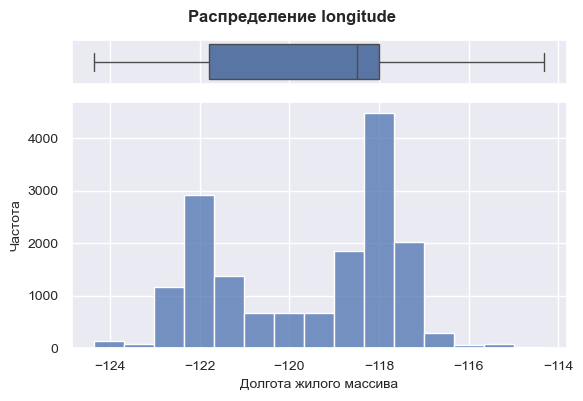

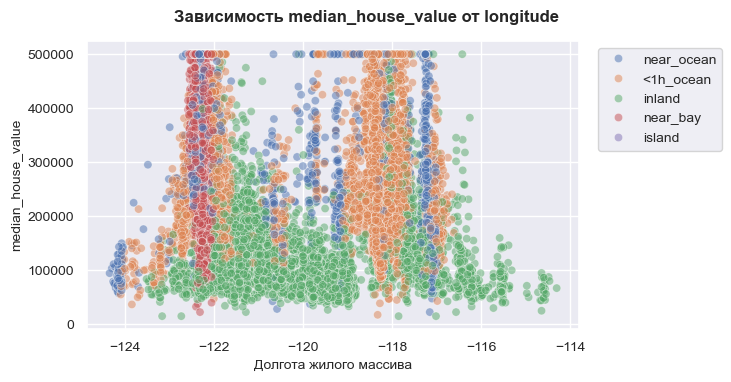

count        mean       std     min     25%     50%     75%  \
longitude  16512.0 -119.564983  1.999196 -124.35 -121.79 -118.49 -118.01   

              max  
longitude -114.31

Тест на нормальность распределения (порог=0.05):
                                                                      
Статистика:                                                  793.33485
Критические значения:              [0.576, 0.656, 0.787, 0.918, 1.092]
Распределение                                   Не является нормальным

In [44]:
analyzis_quantity(df['longitude'], x_label='Долгота жилого массива', target=target, system=True, hue=df['ocean_proximity'])

**Вывод:**

На графиках мы явно наблюдаем 2 района, в каждом есть как и дешевая недвижимость, так и дорогая. И они напрямую не коррелируют с категориальным признаком.

#### Признак "latitude":

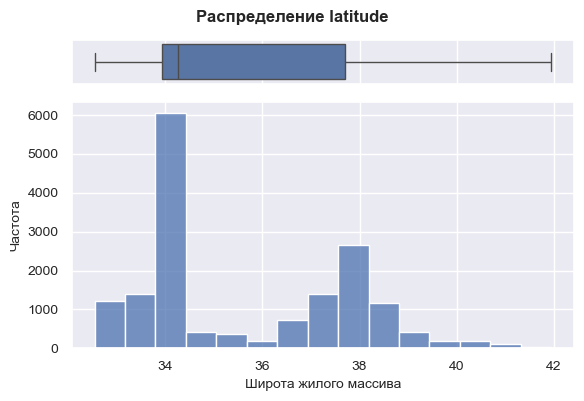

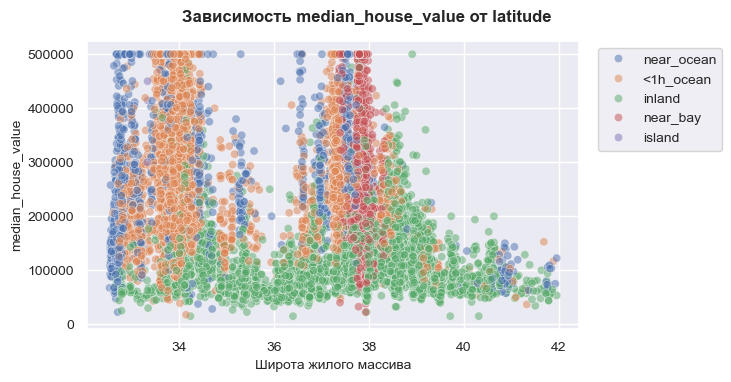

count       mean       std    min    25%    50%    75%    max
latitude  16512.0  35.627574  2.135644  32.54  33.93  34.25  37.71  41.95

Тест на нормальность распределения (порог=0.05):
                                                                      
Статистика:                                                 984.290414
Критические значения:              [0.576, 0.656, 0.787, 0.918, 1.092]
Распределение                                   Не является нормальным

In [45]:
analyzis_quantity(df['latitude'], x_label='Широта жилого массива', target=target, system=True, hue=df['ocean_proximity'])

**Вывод:**

Тут мы наблюдаем ту же картину, что и с долготой, выявлено 2 района. Необходимо рассмотреть эти признаки в совокупности.

#### Признак "latitude" и "longitude":

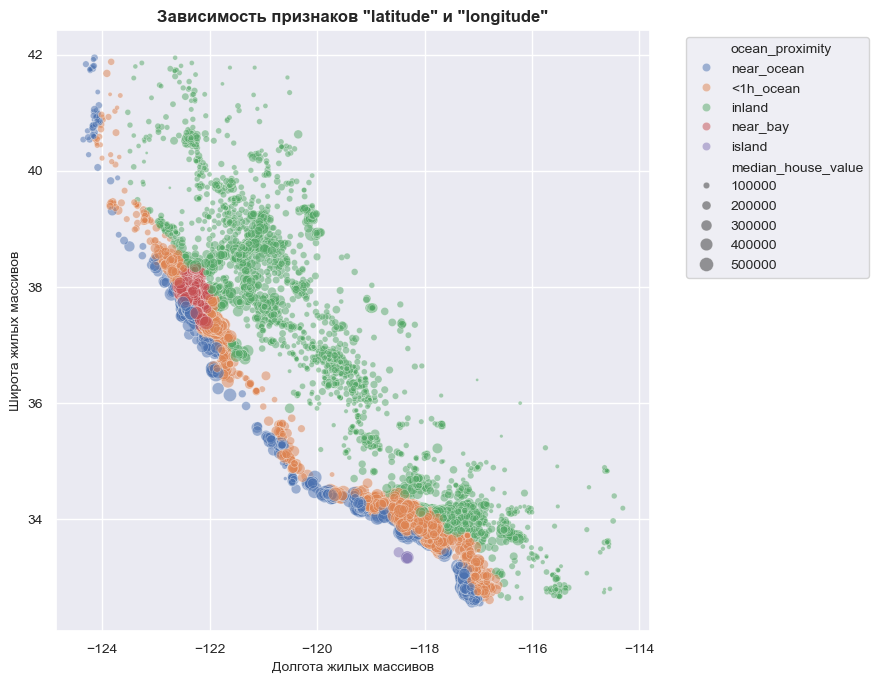

In [46]:
# Построение графика
fig, ax = plt.subplots(figsize=(9, 7))
sns.scatterplot(x=df['longitude'], y=df['latitude'], hue=df['ocean_proximity'], size=target, sizes=(5, 100), alpha=0.5)

# Настройка заголовков и подписей
plt.title('Зависимость признаков "latitude" и "longitude"', fontsize=12, fontweight='bold')
ax.set_xlabel('Долгота жилых массивов', fontsize=10)
ax.set_ylabel('Широта жилых массивов', fontsize=10)
ax.tick_params(axis='both', which='major', labelsize=10)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)

# Отображение графика
fig.tight_layout()
plt.show()

![Карта Калифорнии](https://i.pinimg.com/736x/8d/a0/a9/8da0a909a7a83b4cd7d68f2e476de2c9.jpg)

Мы видим, что скопление жилых массивов связаны с местоположением городов, тем самым мы можем разделить наши жилые массивы либо на кластеры, либо поделить на квадраты, чтобы помочь модели определять район, так как размер точек говорит о том, что местоположение жилого массива помимо близости к океану влияет на медианную цену недвижимости.

К данному вопросу вернемся на этапе корреляционного анализа.

#### Признак "housing_median_age":

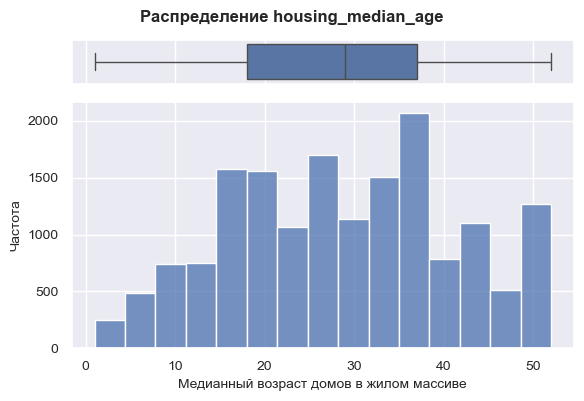

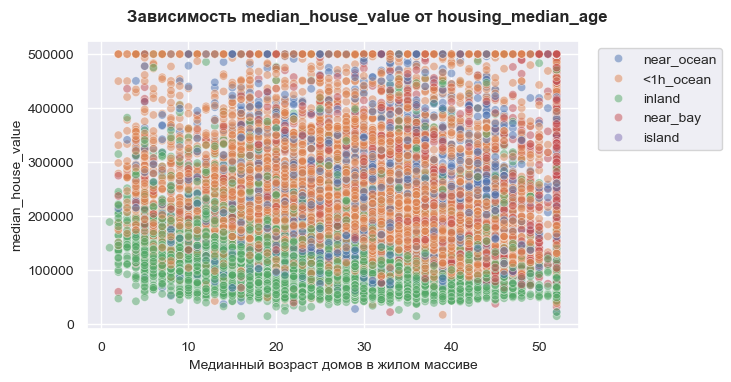

count       mean        std  min   25%   50%   75%   max
housing_median_age  16512.0  28.648074  12.608403  1.0  18.0  29.0  37.0  52.0

Тест на нормальность распределения (порог=0.05):
                                                                      
Статистика:                                                  69.135425
Критические значения:              [0.576, 0.656, 0.787, 0.918, 1.092]
Распределение                                   Не является нормальным

In [47]:
analyzis_quantity(df['housing_median_age'], x_label='Медианный возраст домов в жилом массиве', 
                  target=target, system=True, hue=df['ocean_proximity'])

Данный признак выглядит достаточно зашумленно, и имеет смысл данный признак упростить, и сократить количество категорий интервалами либо по 5 или по 10 лет. 

#### Признак "total_rooms":

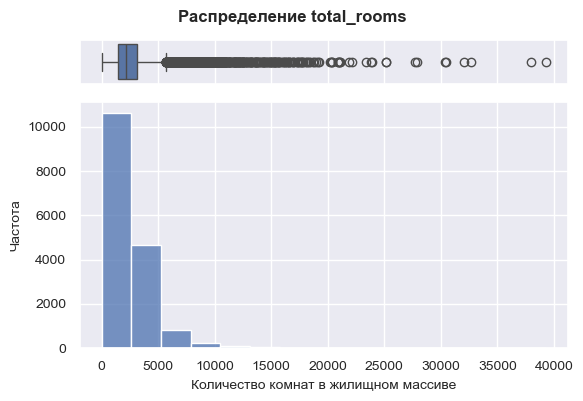

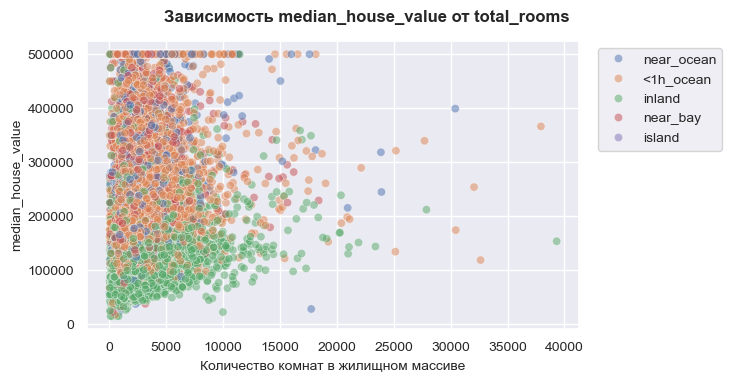

count         mean          std   min     25%     50%     75%  \
total_rooms  16512.0  2634.447311  2160.803761  11.0  1453.0  2128.0  3150.0   

                 max  
total_rooms  39320.0

Тест на нормальность распределения (порог=0.05):
                                                                      
Статистика:                                                 979.689203
Критические значения:              [0.576, 0.656, 0.787, 0.918, 1.092]
Распределение                                   Не является нормальным

In [48]:
analyzis_quantity(df['total_rooms'], x_label='Количество комнат в жилищном массиве', 
                  target=target, system=True, hue=df['ocean_proximity'])

В данном признаке мы видим довольно длинный хвост, что может мешать модели определить верный коэффициент, воспользуемся методом компрессии и последующего клипирования данных.

In [49]:
# Поиск порога сжатия
df['total_rooms'].quantile(0.95)

np.float64(6240.349999999997)

In [51]:
# Компрессия данных
df['total_rooms_comp'] = power_compress(df['total_rooms'], threshold=6240, power=0.9)

In [52]:
# Поиск порога сжатия
df['total_rooms_comp'].quantile(0.85)

np.float64(3938.3500000000004)

In [53]:
# Компрессия данных
df['total_rooms_comp'] = power_compress(df['total_rooms_comp'], threshold=3938, power=0.9)

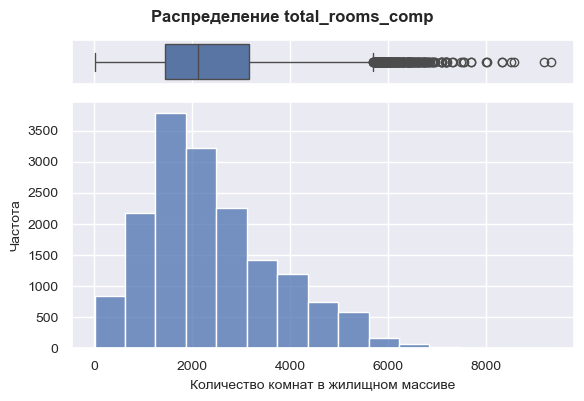

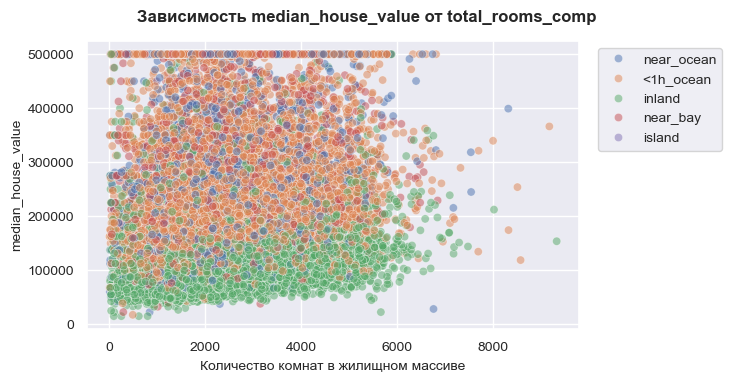

count         mean          std   min     25%     50%  \
total_rooms_comp  16512.0  2395.314413  1310.509272  11.0  1453.0  2128.0   

                     75%         max  
total_rooms_comp  3150.0  9322.39926

Тест на нормальность распределения (порог=0.05):
                                                                      
Статистика:                                                 224.355833
Критические значения:              [0.576, 0.656, 0.787, 0.918, 1.092]
Распределение                                   Не является нормальным

In [54]:
analyzis_quantity(df['total_rooms_comp'], x_label='Количество комнат в жилищном массиве', 
                  target=target, system=True, hue=df['ocean_proximity'])

In [55]:
# Оценка корреляции с таргетом до и после
print(f"Корреляция до: {df['total_rooms'].corr(df['median_house_value']):.3f}")
print(f"Корреляция после: {df['total_rooms_comp'].corr(df['median_house_value']):.3f}")

Корреляция до: 0.137
Корреляция после: 0.177


Наилучший результат дала последовательная степенная компрессия данных с разным порогом срабатывания: 

- Среднее отклонение **уменьшилось в 2 раза**;
- Квартили распределения **остались без изменений**;
- Максимальное значение **сократилось в 4 раза**;
- Линейная корреляция с таргетом **увеличилась на 30%**.

#### Признак "total_bedrooms":

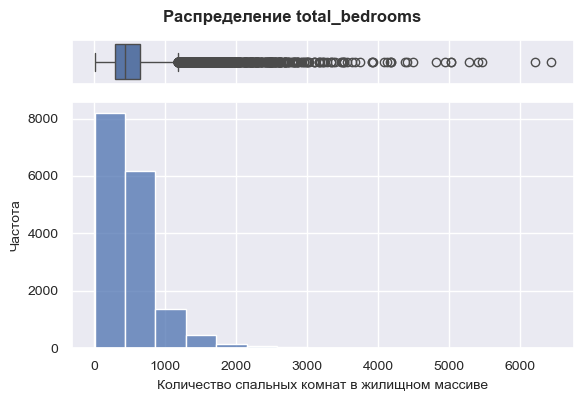

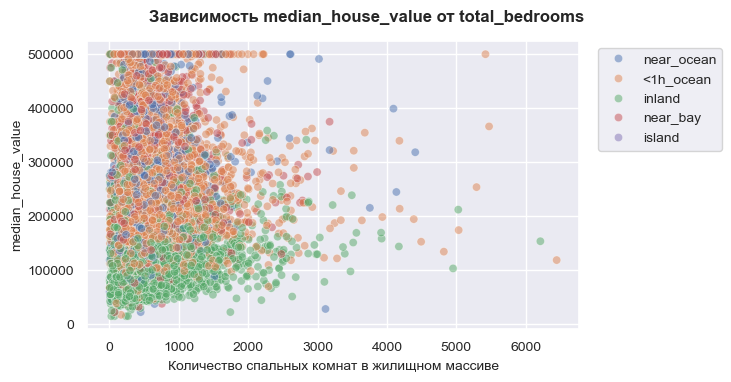

count        mean        std  min    25%    50%    75%  \
total_bedrooms  16512.0  537.611919  416.21723  3.0  296.0  435.0  647.0   

                   max  
total_bedrooms  6445.0

Тест на нормальность распределения (порог=0.05):
                                                                      
Статистика:                                                 871.878885
Критические значения:              [0.576, 0.656, 0.787, 0.918, 1.092]
Распределение                                   Не является нормальным

In [56]:
analyzis_quantity(df['total_bedrooms'], x_label='Количество спальных комнат в жилищном массиве', 
                  target=target, system=True, hue=df['ocean_proximity'])

Ситуация подобна признаку `total_rooms` применим к этому признаку тот же метод компрессии, так как это те же комнаты и чтобы не исказить процентное соотношение мы применяем те же пороги и те же степени сжатия.

In [57]:
# Поиск порога сжатия
df['total_bedrooms'].quantile(0.95)

np.float64(1279.0)

In [58]:
# Компрессия значений 
df['total_bedrooms_comp'] = power_compress(df['total_bedrooms'], threshold=1279, power=0.9)

In [59]:
# Поиск порога сжатия
df['total_bedrooms_comp'].quantile(0.85)

np.float64(812.0)

In [60]:
# Компрессия значений 
df['total_bedrooms_comp'] = power_compress(df['total_bedrooms_comp'], threshold=812, power=0.9)

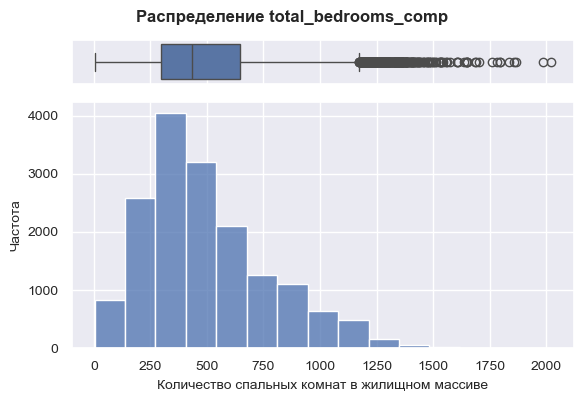

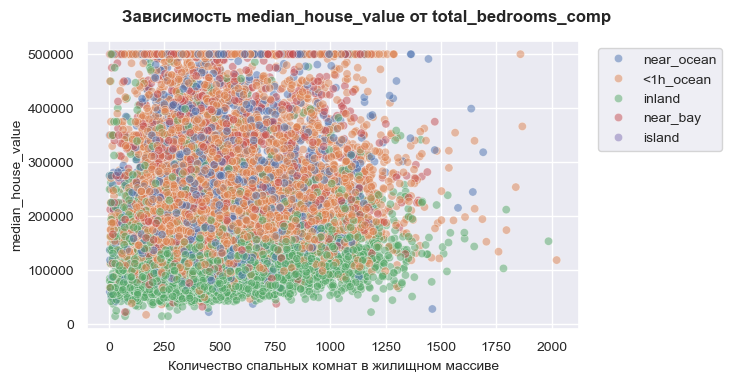

count        mean         std  min    25%    50%  \
total_bedrooms_comp  16512.0  497.550419  279.611142  3.0  296.0  435.0   

                       75%          max  
total_bedrooms_comp  647.0  2022.563033

Тест на нормальность распределения (порог=0.05):
                                                                      
Статистика:                                                 283.117213
Критические значения:              [0.576, 0.656, 0.787, 0.918, 1.092]
Распределение                                   Не является нормальным

In [61]:
analyzis_quantity(df['total_bedrooms_comp'], x_label='Количество спальных комнат в жилищном массиве', 
                  target=target, system=True, hue=df['ocean_proximity'])

In [62]:
# Оценка корреляции с таргетом до и после
print(f"Корреляция до: {df['total_bedrooms'].corr(df['median_house_value']):.3f}")
print(f"Корреляция после: {df['total_bedrooms_comp'].corr(df['median_house_value']):.3f}")

Корреляция до: 0.053
Корреляция после: 0.064


Последовательная степенная компрессия данных с разным порогом срабатывания дала следующий результат: 

- Среднее отклонение **уменьшилось в 1.5 раза**;
- Квартили распределения **остались без изменений**;
- Максимальное значение **сократилось в 3 раза**;
- Линейная корреляция с таргетом **увеличилась на 20%**.

#### Признак "population":

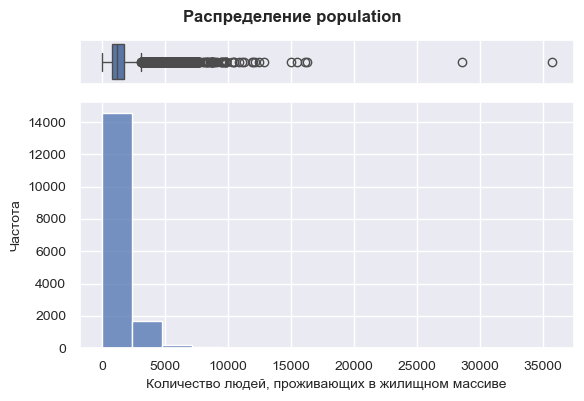

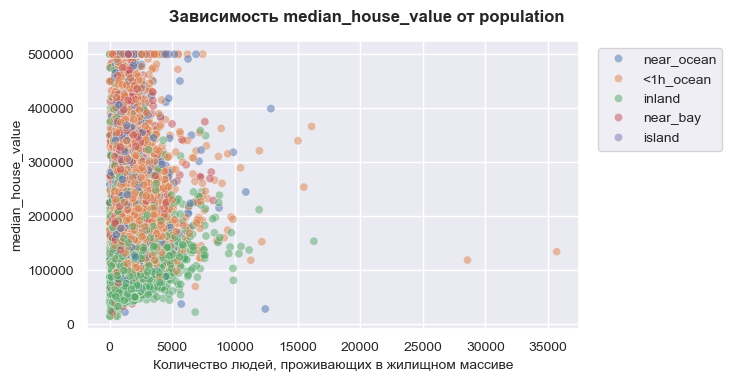

count        mean          std  min     25%     50%     75%  \
population  16512.0  1426.29094  1133.898813  3.0  788.75  1167.0  1728.0   

                max  
population  35682.0

Тест на нормальность распределения (порог=0.05):
                                                                      
Статистика:                                                 862.359205
Критические значения:              [0.576, 0.656, 0.787, 0.918, 1.092]
Распределение                                   Не является нормальным

In [63]:
analyzis_quantity(df['population'], x_label='Количество людей, проживающих в жилищном массиве', 
                  target=target, system=True, hue=df['ocean_proximity'])

In [64]:
# Поиск порога сжатия
df['population'].quantile(0.9999)

np.float64(20582.86289996603)

In [65]:
# Компрессия значений
df['population_comp'] = power_compress(df['population'], threshold=20582, power=0.9)

In [66]:
# Поиск порога сжатия
df['population_comp'].quantile(0.9995)

np.float64(12102.666500000138)

In [67]:
# Компрессия значений
df['population_comp'] = power_compress(df['population_comp'], threshold=12102, power=0.9)

In [68]:
# Поиск порога сжатия
df['population_comp'].quantile(0.97)

np.float64(3911.67)

In [69]:
# Компрессия значений
df['population_comp'] = power_compress(df['population_comp'], threshold=3911, power=0.9)

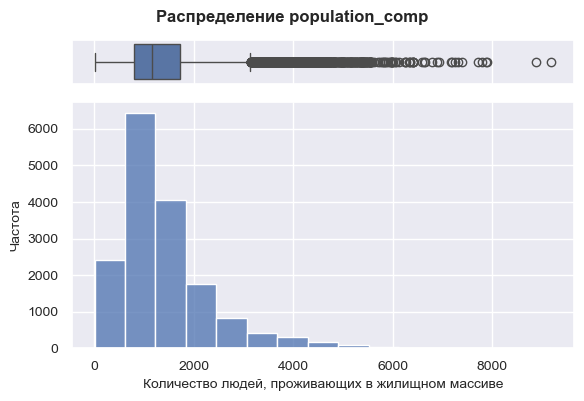

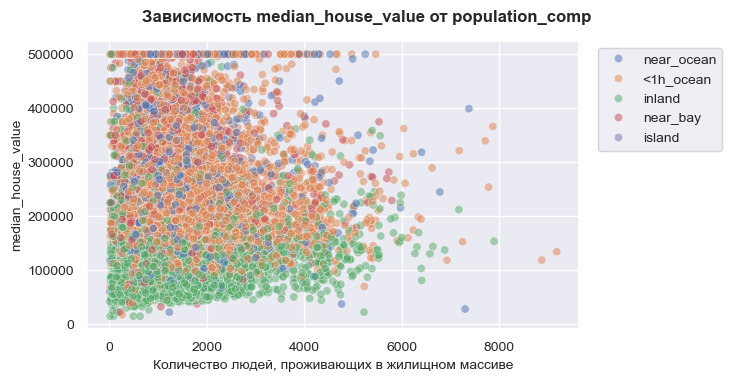

count         mean         std  min     25%     50%  \
population_comp  16512.0  1395.835218  939.785623  3.0  788.75  1167.0   

                    75%          max  
population_comp  1728.0  9184.298398

Тест на нормальность распределения (порог=0.05):
                                                                      
Статистика:                                                 581.902773
Критические значения:              [0.576, 0.656, 0.787, 0.918, 1.092]
Распределение                                   Не является нормальным

In [70]:
analyzis_quantity(df['population_comp'], x_label='Количество людей, проживающих в жилищном массиве', 
                  target=target, system=True, hue=df['ocean_proximity'])

In [71]:
# Оценка корреляции с таргетом до и после
print(f"Корреляция до: {df['population'].corr(df['median_house_value']):.3f}")
print(f"Корреляция после: {df['population_comp'].corr(df['median_house_value']):.3f}")

Корреляция до: -0.025
Корреляция после: -0.028


Последовательная степенная компрессия данных с разным порогом срабатывания дала следующий результат: 

- Среднее отклонение **уменьшилось на 20%**;
- Квартили распределения **остались без изменений**;
- Максимальное значение **сократилось в 4 раза**;
- Линейная корреляция с таргетом **увеличилась на 12%**.

#### Признак "households":

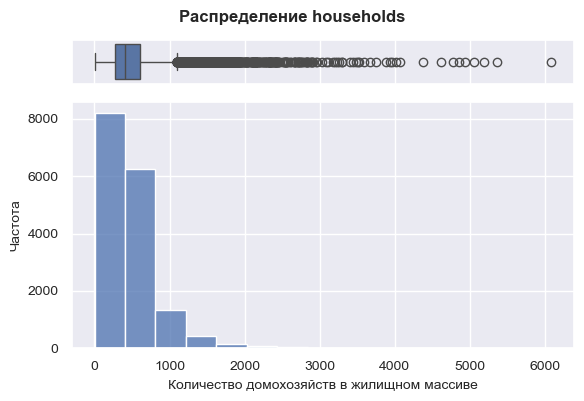

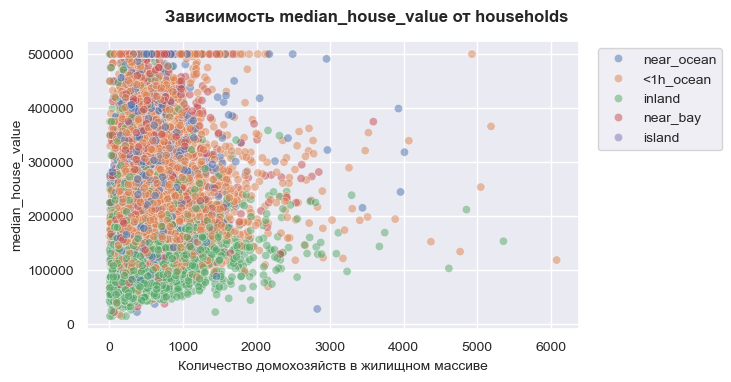

count        mean         std  min    25%    50%     75%     max
households  16512.0  499.572069  378.760608  2.0  280.0  410.0  605.25  6082.0

Тест на нормальность распределения (порог=0.05):
                                                                      
Статистика:                                                 816.833844
Критические значения:              [0.576, 0.656, 0.787, 0.918, 1.092]
Распределение                                   Не является нормальным

In [72]:
analyzis_quantity(df['households'], x_label='Количество домохозяйств в жилищном массиве', 
                  target=target, system=True, hue=df['ocean_proximity'])

In [73]:
# Поиск порога сжати
df['households'].quantile(0.99)

np.float64(1928.6699999999983)

In [74]:
# Компрессия значений 
df['households_comp'] = power_compress(df['households'], threshold=1928, power=0.9)

In [75]:
# Поиск порога сжати
df['households_comp'].quantile(0.98)

np.float64(1584.7799999999988)

In [76]:
df['households_comp'] = power_compress(df['households_comp'], threshold=1584, power=0.9)

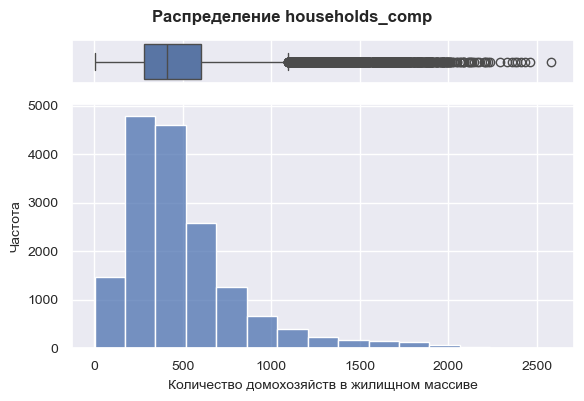

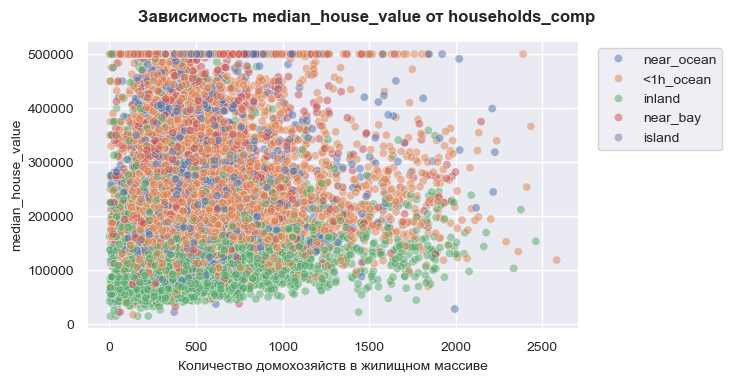

count        mean         std  min    25%    50%     75%  \
households_comp  16512.0  491.887331  333.281403  2.0  280.0  410.0  605.25   

                         max  
households_comp  2581.977157

Тест на нормальность распределения (порог=0.05):
                                                                      
Статистика:                                                 632.748841
Критические значения:              [0.576, 0.656, 0.787, 0.918, 1.092]
Распределение                                   Не является нормальным

In [77]:
analyzis_quantity(df['households_comp'], x_label='Количество домохозяйств в жилищном массиве', 
                  target=target, system=True, hue=df['ocean_proximity'])

In [78]:
# Оценка корреляции с таргетом до и после
print(f"Корреляция до: {df['households'].corr(df['median_house_value']):.3f}")
print(f"Корреляция после: {df['households_comp'].corr(df['median_house_value']):.3f}")

Корреляция до: 0.069
Корреляция после: 0.074


Последовательная степенная компрессия данных с разным порогом срабатывания дала следующий результат: 

- Среднее отклонение **уменьшилось на 12%**;
- Квартили распределения **остались без изменений**;
- Максимальное значение **сократилось в 2 раза**;
- Линейная корреляция с таргетом **увеличилась на 7%**.

#### Признак "median_income":

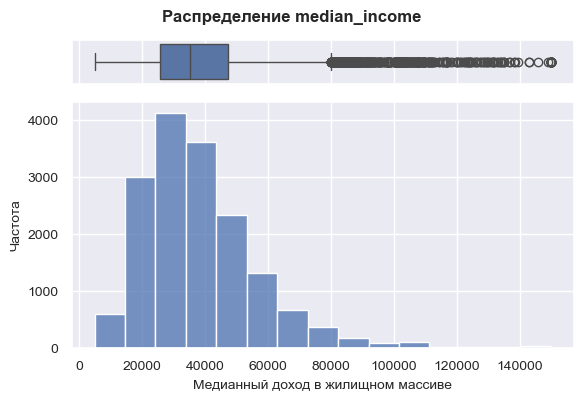

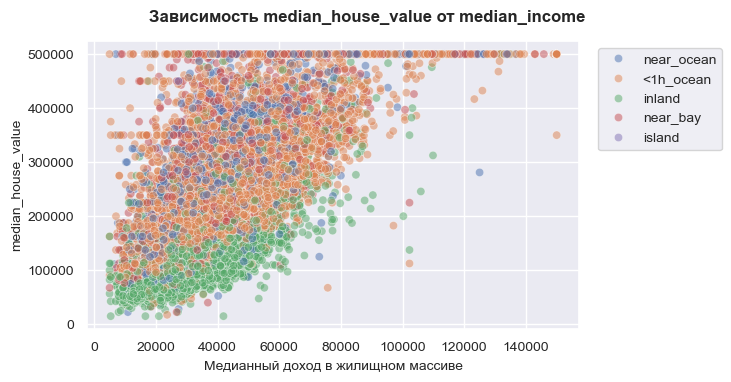

count          mean           std     min       25%      50%  \
median_income  16512.0  38740.367854  18998.894192  4999.0  25669.25  35387.5   

                    75%       max  
median_income  47405.75  150001.0

Тест на нормальность распределения (порог=0.05):
                                                                      
Статистика:                                                  311.49711
Критические значения:              [0.576, 0.656, 0.787, 0.918, 1.092]
Распределение                                   Не является нормальным

In [79]:
analyzis_quantity(df['median_income'], x_label='Медианный доход в жилищном массиве', 
                  target=target, system=True, hue=df['ocean_proximity'])

В данному признаке компрессия будет излишней, возможно имеет смысл разделить данный признак на категории.

#### Признак "median_house_value":

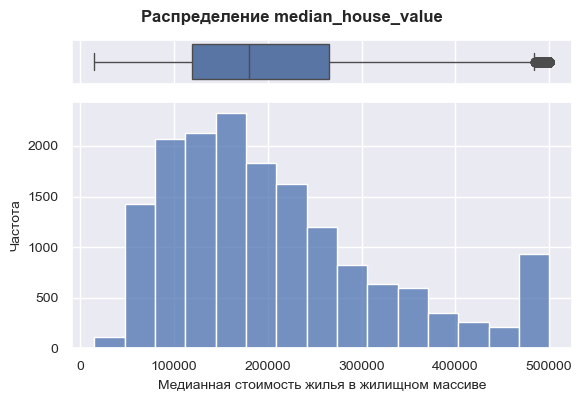

count           mean            std      min       25%  \
median_house_value  16512.0  207092.198825  115856.995641  14999.0  119400.0   

                         50%       75%       max  
median_house_value  180000.0  265300.0  500001.0

Тест на нормальность распределения (порог=0.05):
                                                                      
Статистика:                                                 405.253615
Критические значения:              [0.576, 0.656, 0.787, 0.918, 1.092]
Распределение                                   Не является нормальным

In [80]:
analyzis_quantity(df['median_house_value'], x_label='Медианная стоимость жилья в жилищном массиве')

У нас есть пик на значениях **500001**, что говорит о цензурировании стоимости жилья в элитных районах.

### Категориальные признаки:

#### Признак "ocean_proxinity":

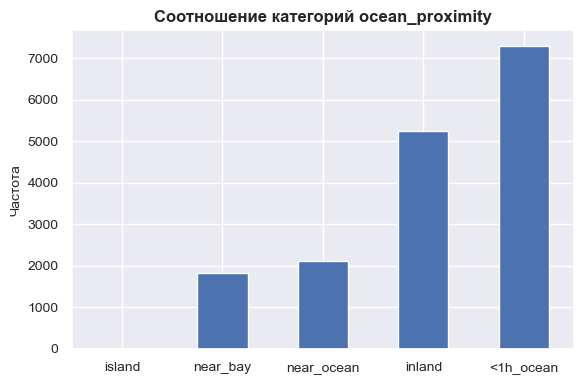

In [88]:
analyzis_category(df['ocean_proximity'])

Количество жилых районов на островах слишком мало, так же, вернувшись к графику долготы и широты возникает вопрос, а нужно ли нам столько категорий, не усложняет ли нам это модель, на этапе `feature engineering` воспользуемся статистическим тестом `ANOVA`, чтобы определить действительно ли в них есть отличие.

### Вывод:

#### Карта цен — это карта городов.


Признаки `longitude` и `latitude` показали, что высокие цены сосредоточены не случайно — они кластеризуются вокруг крупных городов Калифорнии *(Лос-Анджелес, Сан-Франциско, Сан-Диего и т.д.)*.


➤ **Решение**: Создадим новый категориальный признак — `urban_area` — на основе кластеризации координат. Это даст модели "понимание географии" рассматриваемой местности.

---

#### Длинный хвосты распределений количественных признаков.


Большинство числовых признаков (доход, возраст жилья и др.) имеют сильную правую асимметрию + выбросы.


➤ **Решение**: Применили компрессию значений — выбросы больше не доминируют, но информация сохранена и корреляция с тергетом в этих признаках усилена.

---

#### Признаки `housing_median_age` и `median_income`.


Признаки `housing_median_age` и `median_income` имеют десятки уникальных значений — модель может запутаться.

➤ **Решение**: Преобразуем их в порядковые группы (например: «низкий/средний/высокий доход») — и проверим через корреляцию, не потеряли ли мы важную информацию. 

---

#### Целевая переменная — не просто ассиметрична, она законно обрезана.


На конце распределения небольшой пик — это цензурирование. В данных нет цен выше определённого порога *(возможно, ограничение сбора или законодательное ограничение)*.


➤ **Проблема**: Модель может ошибочно интерпретировать этот пик как реальную «пиковую» цену.


➤ **Статус**: Решение пока не найдено — но мы его не игнорируем. Проверим влияние на валидации и рассмотрим методы работы с цензурированными данными. 

---

#### `Ocean_proximity` — но стоит ли делить на 5 категорий?


Признак `ocean_proximity` имеет 5 уровней, но районы на островах — редкость. Мы подозреваем, что некоторые категории не несут смысловой нагрузки.


➤ **Решение**: Используем `ANOVA`, чтобы проверить — действительно ли все категории отличаются по цене. Если нет — объединим их. Меньше категорий = проще модель = меньше переобучения. 

## Корреляционный анализ:

### Матрица корреляции:

Так как нас интересует только линейная зависимость, мы будем использовать метод Пирсона.

In [98]:
# Количественные признаки
num_col = df.columns.drop('ocean_proximity').tolist()

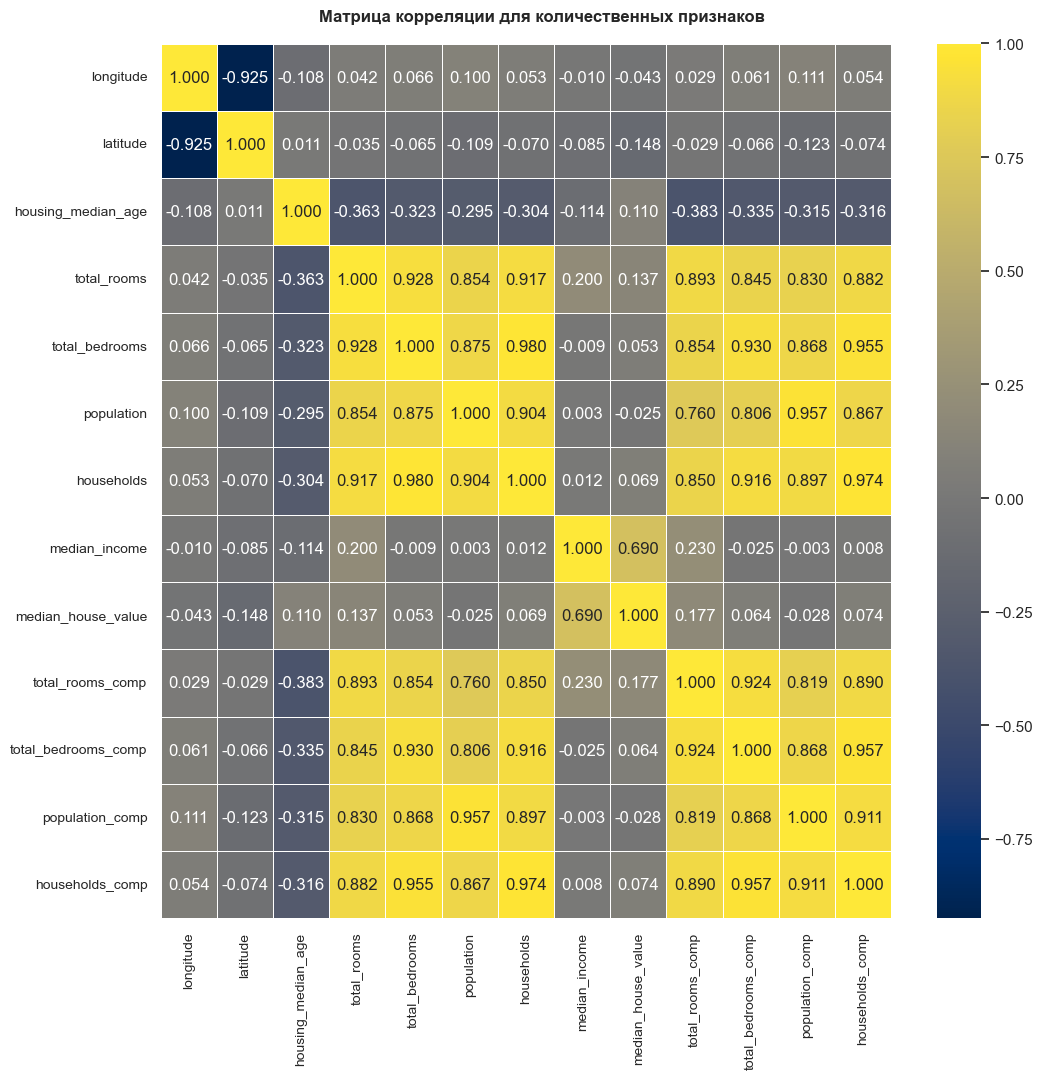

In [103]:
# Построение матрицы корреляции
fig, ax = plt.subplots(figsize=(11, 11))
sns.heatmap(df[num_col].corr(), annot=True, 
            fmt='.3f', linewidths=.5, cmap='cividis', ax=ax)

# Настройка заголовка и подписей
fig.suptitle('Матрица корреляции для количественных признаков', fontweight='bold', fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.xticks(rotation=90)

# Отображаем график
plt.tight_layout()
plt.show()

Скомпрессированные признаки показывают корреляцию с таргетом немного выше, чем оригинальные признаки, следовательно от оригинальных можем отказаться.

Наблюдаем сильную зависимость между ними, проверим их на наличие мультиколлениарности между ними.

### VIF-фактор:

In [105]:
# Список признаков для оценки наличия мультиколлениарности
multicol = ['total_rooms_comp',
            'total_bedrooms_comp',
            'population_comp',
            'households_comp']

In [106]:
# VIF-фактор
vif_factor(df, multicol)

input attribute        vif
0     total_rooms_comp  28.623549
1  total_bedrooms_comp  62.615344
2      population_comp  18.458825
3      households_comp  46.916621

У всех признаков значения выше **10**, что говорит о наличие мультиколлинеарности.

Всех их объединяет общее количество домойхозяйств, разделим первые 3 признака на `households_comp`, чтобы получить среднее значение для каждого жилого массива.

In [107]:
# Создание новых признаков
df['mean_rooms'] = df['total_rooms_comp'] / df['households_comp']
df['mean_bedrooms'] = df['total_bedrooms_comp'] / df['households_comp']
df['mean_population'] = df['population_comp'] / df['households_comp']

In [109]:
# Повторная оценка мультиколлинеарности
# Список признаков
multicol = ['households_comp',
            'mean_rooms',
            'mean_bedrooms',
            'mean_population']

In [110]:
# VIF-фактор
vif_factor(df, multicol)

input attribute        vif
0  households_comp   2.130823
1       mean_rooms  22.368140
2    mean_bedrooms  24.134453
3  mean_population   1.097986

У средних количеств комнат и спален еще есть сильная зависимость, избавимся от нее возведением одного признака в степень.

In [111]:
# Создание новых признаков
df['mean_bedrooms^2'] = df['mean_bedrooms'] ** 2

In [112]:
# Повторная оценка мультиколлинеарности
# Список признаков
multicol = ['households_comp',
            'mean_rooms',
            'mean_bedrooms^2',
            'mean_population']

# VIF-фактор
vif_factor(df, multicol)

input attribute       vif
0  households_comp  2.193477
1       mean_rooms  2.906862
2  mean_bedrooms^2  1.464631
3  mean_population  1.102953

Отлично, мы избавились от мультиколлинеарности.

In [115]:
# Очистим датасет от неактуальных признаков
# Список признаков на удаление
drop_lst = ['total_rooms',
            'total_bedrooms',
            'population',
            'households',
            'total_rooms_comp',
            'total_bedrooms_comp',
            'population_comp',
            'mean_bedrooms']

# Удаление признаков
df.drop(drop_lst, axis=1, inplace=True)

Повторно рассмотрим матрицу корреляции.

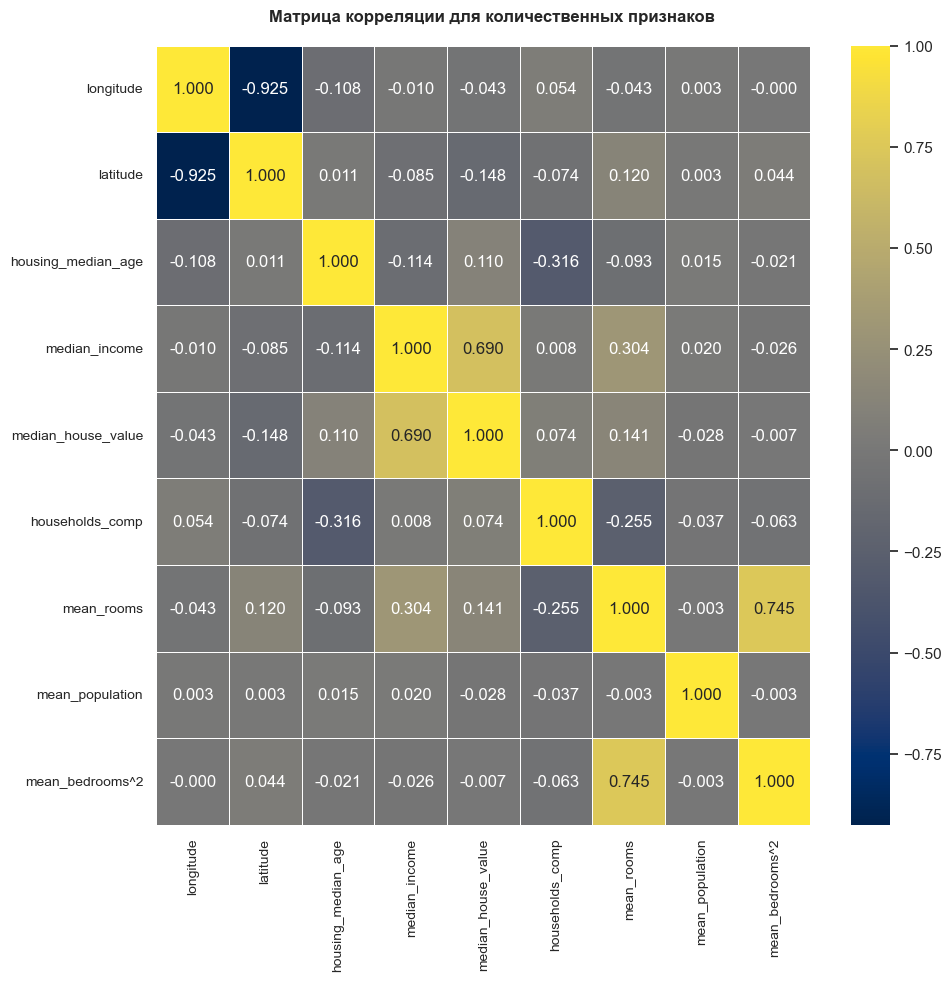

In [118]:
# Количественные признаки
num_col = df.columns.drop('ocean_proximity').tolist()

# Построение матрицы корреляции
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(df[num_col].corr(), annot=True, 
            fmt='.3f', linewidths=.5, cmap='cividis', ax=ax)

# Настройка заголовка и подписей
fig.suptitle('Матрица корреляции для количественных признаков', fontweight='bold', fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.xticks(rotation=90)

# Отображаем график
plt.tight_layout()
plt.show()

У нас остались еще признаки долготы и широты, которые сильно взаимосвязаны, но мы о них не переживаем, так как мы их преобразуем в новый категориальный признак с помощью кластеризации на этапе `feature engineering`.

Признаки `mean_rooms` и `mean_bedrooms` еще сильно связаны, но с таргетом не сильно, попробуем усилить их влияние через анализ независимых компонент, получив 1 или 2 признака с более сильной связью с таргетом.

Далее, добавим категориальные признаки с доходом жильцов и медианным возрастом жилого массива и оценим корреляцию с помощью матрицы `Phik`.

### Преобразование признаков "median_income" и "housing_median_age":

## Feature engineering:

*На данном этапе создадим те признаки, о которых говорили на предыдущих этапах работы.*

### Признак "urban_area":

Наша цель, создать категориальных признак, которых будет делить данные на кластеры, которые должны служить делению на города и прилегающей к ним местность.

In [ ]:
# Преобразования долготы и широты в 3д координаты
coords_3d = to_3d(df['latitude'], df['longitude'])

Помимо координат для кластеризации мы воспользуемся еще информацией о численности населения, количества домохозяйств и медианном доходе.

In [ ]:
# Инициализация StandardScaler
claster_scaler = StandardScaler()

# Дополнительные признаки
extra_features = df[['median_income']].values

# Масштабирование дополнительных признаков
extra_features_scaled = claster_scaler.fit_transform(extra_features)

In [ ]:
# Объединение массивов
urban_cluster = np.hstack([coords_3d, extra_features_scaled])

Определим оптимальное количество кластеров, с помощью метода локтя.

In [ ]:
# Получаем данные о inertia
n_clusters_range = range(1, 25)
inertias = []

for n in n_clusters_range:
    kmeans = MiniBatchKMeans(n_clusters=n, random_state=RANDOM_STATE)
    kmeans.fit(urban_cluster)
    inertias.append(kmeans.inertia_)

In [ ]:
# Строим график
fig = plt.subplots(figsize=(6, 4))
sns.pointplot(x=n_clusters_range, y=inertias)

# Настройка заголовка и подписей
plt.title('Метод локтя для выбора оптимального числа кластеров', fontweight='bold', fontsize=12)
plt.xlabel('Количество кластеров (n_clusters)', fontsize=10)
plt.ylabel('Инерция (Inertia)', fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Вывод графика
plt.tight_layout()
plt.show()

Метод локтя указывает, что оптимальное кличество кластеров ровно **5**. Получим эти кластеры и визуализируем на карте.

In [ ]:
# Инициализируем модель для кластеризации
kmeans = MiniBatchKMeans(n_clusters=5, random_state=RANDOM_STATE)

In [ ]:
# Получаем новый признак
df['urban_area'] = kmeans.fit_predict(urban_cluster)

In [ ]:
# Визуализация итогов кластеризации
# Построение графика
fig, ax = plt.subplots(figsize=(9, 7))
sns.scatterplot(x=df['longitude'], y=df['latitude'], hue=df['urban_area'], 
                size=target, sizes=(5, 25), alpha=0.5, palette='cividis')

# Настройка заголовков и подписей
plt.title('Зависимость признаков "latitude" и "longitude"', fontsize=12, fontweight='bold')
ax.set_xlabel('Долгота жилых массивов', fontsize=10)
ax.set_ylabel('Широта жилых массивов', fontsize=10)
ax.tick_params(axis='both', which='major', labelsize=10)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)

# Отображение графика
fig.tight_layout()
plt.show()

In [ ]:
# Датафрейм для анализа признаков
df_phik = df[['median_house_value', 'urban_area']].copy()
df_phik['median_house_value'] = df_phik['median_house_value'].astype('float')
df_phik['urban_area'] = df_phik['urban_area'].astype('category')

# Строим тепловую карту
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(df_phik.phik_matrix(interval_cols=['median_house_value']), annot=True, 
            fmt='.2f', linewidths=.5, cmap='cividis', ax=ax)

# Настройка заголовка и подписей
f.suptitle('Матрица Phik для анализа взаимосвязей признаков', fontsize=12)

# Отображаем график
plt.tight_layout()
plt.show()

In [ ]:
df.head()

In [ ]:
df.info()